In [1]:

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image


import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from typing import Tuple, NoReturn
import seaborn as sns
import time
from utils.model_utils import *
from utils.plot_utils import *
from utils.trainer import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((64,64))])
dataset = ImageFolder("./data/",transform)

train_dataset,test_dataset = random_split(dataset,[round(0.7 * len(dataset)), round(0.3 * len(dataset))])

In [3]:
BATCH_SIZE = 16
SHUFFLE = True
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


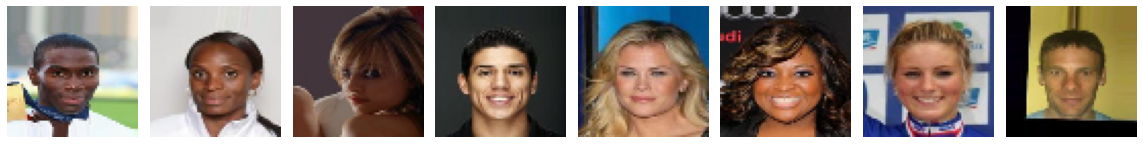

In [4]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # data = std * data + mean
    data = np.clip(data, 0, 1)

    plt.figure(figsize=(8*2, 4*2))
    for i in range(8):
        plt.subplot(4, 8, i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()

imgs,_ = next(iter(train_loader))
show_grid(imgs)


In [5]:
#Layers implementation from https://github.com/AntixK/PyTorch-VAE/blob/master/models/cvae.py

class ConvVAE(nn.Module):

    def __init__(self, img_channels=3, out_channels=[32, 64, 128, 256, 512], zdim=128, fdim=512*4):
        """ Model initlaizer """

        super().__init__()

        self.out_channels = out_channels
        self.fdim = fdim
        self.zdim = zdim
        self.img_channel = img_channels
        self.encoder = self._make_encoder()
        self.decoder = self._make_decoder()
        self.fc_mu = nn.Linear(fdim, zdim)
        self.fc_sigma = nn.Linear(fdim, zdim)

        return

    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    def _make_encoder(self):
        layers = []
        in_channels = self.img_channel
        for h_dim in self.out_channels:
            layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        encoder = nn.Sequential(*layers)

        return encoder

    def _make_decoder(self):

        modules = []

        self.decoder_input = nn.Linear(self.zdim, self.out_channels[-1] * 4)

        self.out_channels.reverse()

        for i in range(len(self.out_channels) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(self.out_channels[i],
                                       self.out_channels[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(self.out_channels[i + 1]),
                    nn.LeakyReLU())
            )

        decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(self.out_channels[-1],
                               self.out_channels[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(self.out_channels[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(self.out_channels[-1], out_channels=3,
                      kernel_size=3, padding=1),
            nn.Tanh())
        return decoder

    def forward(self, x):

        out = self.encoder(x)
        out = torch.flatten(out, 1)
        mu = self.fc_mu(out)
        log_var = self.fc_sigma(out)

        z = self.reparameterize(mu, log_var)

        z_in = self.decoder_input(z)
        z_in = z_in.view(-1, 512, 2, 2)
        x_hat = self.decoder(z_in)
        x_hat = self.final_layer(x_hat)

        return x_hat, (z, mu, log_var)



In [6]:
vae = ConvVAE()


In [7]:
vae.to(device)

ConvVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Seque

In [8]:
def vae_loss_function(recons, target, mu, log_var, lambda_recons=1, lambda_elbo=1):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    recons_loss = F.mse_loss(recons, target, reduction="sum")
    b_size = recons.shape[0]
#     recons_loss = F.binary_cross_entropy(recons.view(b_size,-1), target.view(b_size,-1), reduction='sum')
    elbo = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (lambda_recons * recons_loss + lambda_elbo * elbo) / b_size, (recons_loss, elbo)


In [9]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """

    loss_list = []
    recons_loss = []
    vae_loss = []

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        images = images.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass
        recons, (z, mu, log_var) = model(images)

        # Calculate Loss
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        progress_bar.set_description(
            f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")

    mean_loss = np.mean(loss_list)

    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath=""):
    """ Evaluating the model for either validation or test """
    loss_list = []
    recons_loss = []
    vae_loss = []

    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)

        # Forward pass
        recons, (z, mu, log_var) = model(images)

        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())

        if(i == 0 and savefig):
            save_image(recons[:64].cpu(), os.path.join(
                savepath, f"recons{epoch}.png"))

    # Total correct predictions and loss
    loss = np.mean(loss_list)

    return loss


In [10]:
def train_model(model, optimizer, scheduler, criterion, train_loader,
                valid_loader, num_epochs, savepath, save_frequency=5):
    """ Training a model for a given number of epochs"""

    train_loss = []
    val_loss = []
    loss_iters = []

    for epoch in range(num_epochs):

        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % 5 == 0 or epoch == num_epochs - 1)
        loss = eval_model(
            model=model, eval_loader=valid_loader, criterion=criterion,
            device=device, epoch=epoch, savefig=log_epoch, savepath=savepath
        )
        val_loss.append(loss)

        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
            model=model, train_loader=train_loader, optimizer=optimizer,
            criterion=criterion, epoch=epoch, device=device
        )

        # PLATEAU SCHEDULER
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters

        if(epoch % save_frequency == 0):
            stats = {
                "train_loss": train_loss,
                "valid_loss": val_loss,
                "loss_iters": loss_iters,
                "name": "conv_vae"
            }
            save_model(model=model, optimizer=optimizer,
                       epoch=epoch, stats=stats, name='conv_vae')

        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")

    print(f"Training completed")
    return train_loss, val_loss, loss_iters


In [11]:
savepath = "imgs/conv_vae/"
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-3)

# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=5, factor=0.1, verbose=True)

train_loss, val_loss, loss_iters = train_model(
    model=vae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
    train_loader=train_loader, valid_loader=test_loader, num_epochs=25, savepath=savepath
)


Epoch 1 Iter 8864: loss 293.94962. : 100%|██████████| 8864/8864 [01:49<00:00, 81.14it/s]


    Train loss: 345.3692
    Valid loss: 3669.3943


Epoch 6 Iter 8864: loss 282.60718. : 100%|██████████| 8864/8864 [01:48<00:00, 81.38it/s]


    Train loss: 236.6125
    Valid loss: 231.24094


Epoch 11 Iter 8864: loss 266.09570. : 100%|██████████| 8864/8864 [01:49<00:00, 80.65it/s]


    Train loss: 229.26566
    Valid loss: 226.78095


Epoch 16 Iter 8864: loss 227.12421. : 100%|██████████| 8864/8864 [01:50<00:00, 80.37it/s]


    Train loss: 225.46449
    Valid loss: 228.41312


Epoch 21 Iter 8864: loss 241.78441. : 100%|██████████| 8864/8864 [01:51<00:00, 79.37it/s]


    Train loss: 222.97558
    Valid loss: 220.77358


Epoch 25 Iter 8864: loss 207.67351. : 100%|██████████| 8864/8864 [01:48<00:00, 81.78it/s]

    Train loss: 221.44521
    Valid loss: 221.44791
Training completed


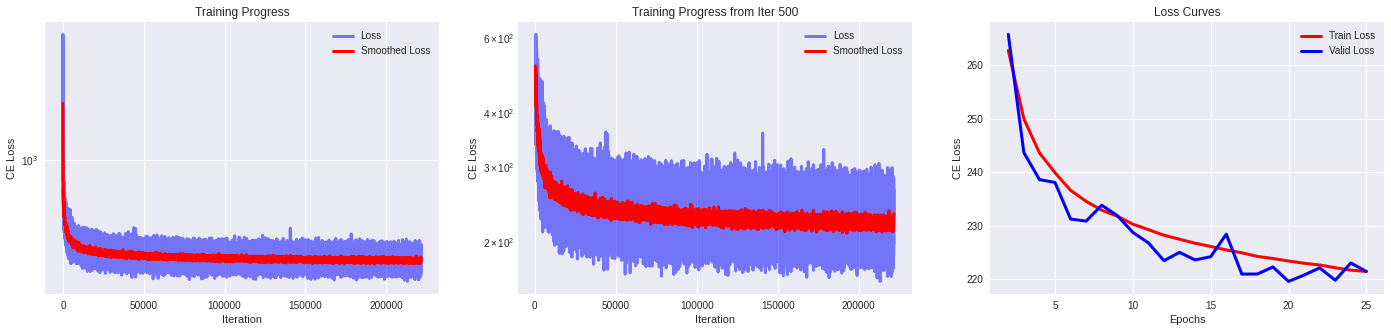

In [13]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(24, 5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_yscale("log")
ax[0].set_title("Training Progress")

smooth_loss = smooth(loss_iters, 31)
START = 500
N_ITERS = len(loss_iters)
ax[1].plot(np.arange(START, N_ITERS), loss_iters[START:],
           c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:],
           c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title(f"Training Progress from Iter {START}")

epochs = np.arange(len(train_loss)) + 1
ax[2].plot(epochs[1:], train_loss[1:], c="red",
           label="Train Loss", linewidth=3)
ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("CE Loss")
ax[2].set_title("Loss Curves")


plt.show()

In [ ]:
COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
          'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]


def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """

    legend = [f"Class {l}" for l in np.unique(
        labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1, 1, figsize=(12, 6))

    for i, l in enumerate(np.unique(labels)):
        idx = np.where(l == labels)

        ax.scatter(points[idx, 0], points[idx, 1],
                   label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")


In [12]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = model(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0], -1))
        latents.append(z.cpu())
        labels.append(lbls)

imgs_flat = np.concatenate(imgs_flat)
latents = np.concatenate(latents)
labels = np.concatenate(labels)


NameError: name 'model' is not defined

In [ ]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)

# N = 2000
fig, ax = plt.subplots(1, 2, figsize=(26, 8))
display_projections(pca_imgs[:N], labels[:N],
                    ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("PCA Proj. of Images")
display_projections(latents[:N], labels[:N],
                    ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("Encoded Representations")
plt.show()
